In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import regression_funs as rfu
import funs as fu
import geopandas

import matplotlib.gridspec as gridspec

from sklearn.linear_model import ElasticNetCV

import cartopy.crs as ccrs

In [106]:
OUT_FILE = '../data_out2/20_BC_sources_inverse.csv'
OUT_DS_FILE = '../data_out2/DS_20__BC_sources_inverse.nc'
OUT_CONTRS_FILE = '../data_out2/CONTRS_20__BC_sources_inverse.csv'
OUT_MEAS_FILE = '../data_out2/MEAS_20__BC_sources_inverse.csv'


LA = 'lat'
LO = 'lon'
AT = 'AIRTRACER'
L = 'lab'
PAR = 'BC'
SIC = 'sorted_inf_clusters'
T = 'time'
U = '[ng/m3]'

pol_dic = {
    1	:'a'	,
    2	:'a'	,
    5	:'a'	,
    6	:'a'	,
    3	:'b'	,
    4	:'c'	,
    7	:'d'	,
}

MAP_CM = 'Reds'


cols = {
 'a':'C0',
 'b':'C2',
 'c':'C4',
 'd':'C6',
}

In [116]:
yn = pd.read_csv(OUT_MEAS_FILE,index_col='time',parse_dates=True).iloc[:,0]

In [118]:
ds = xr.open_dataset(OUT_DS_FILE)

In [119]:
df = pd.read_csv(OUT_FILE,index_col='time',parse_dates=True)
df.columns=df.columns.astype(float)

In [120]:
cf = pd.read_csv(OUT_CONTRS_FILE,index_col='time',parse_dates=True)
cf.columns=cf.columns.astype(int)

In [121]:
def _merge(df,pol_dic):
    df1 = df[pol_dic.keys()].sum().replace(pol_dic)
    df1.name = 'i'

    a = pd.merge(df1,pd.Series(pol_dic, name='n'),left_index=True,right_index=True).groupby('n').sum()
    return a 
_merge(df,pol_dic)

,i
n,
a,39580.062134
b,8953.731669
c,6651.858316
d,2745.531932


DatetimeIndex(['2019-10-01 00:00:00', '2019-10-01 03:00:00',
               '2019-10-01 06:00:00', '2019-10-01 09:00:00',
               '2019-10-01 12:00:00', '2019-10-01 15:00:00',
               '2019-10-01 18:00:00', '2019-10-01 21:00:00',
               '2019-10-02 00:00:00', '2019-10-02 03:00:00',
               ...
               '2020-09-28 09:00:00', '2020-09-28 12:00:00',
               '2020-09-28 15:00:00', '2020-09-28 18:00:00',
               '2020-09-28 21:00:00', '2020-09-29 00:00:00',
               '2020-09-29 03:00:00', '2020-09-29 06:00:00',
               '2020-09-29 09:00:00', '2020-09-29 12:00:00'],
              dtype='datetime64[ns]', name='time', length=1451, freq=None)

<GeoAxesSubplot:xlabel='lon', ylabel='lat'>

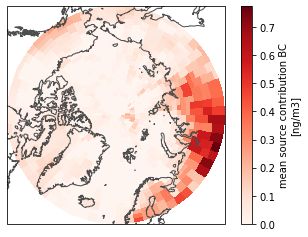

In [133]:
def _plt(ds,contr,ax=None):
    import matplotlib as mpl
    # pred, cdf, y, yn, dp, regr = rfu.elastic_net_reg2(dsf, dm, PAR)
    
    ds_ = ds

    _1 = ds_[L].to_series().replace(contr.to_dict()).to_xarray()
    _1.name = f'mean source contribution {PAR} {U}'

    if ax is None:
        _, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Orthographic(0, 90)))
    ax.coastlines(color='0.3')
#     ax.gridlines(color='.7')
    _1.plot(ax=ax, transform=ccrs.PlateCarree(),vmin=0,cmap=MAP_CM)
    return ax 
_plt(ds,cf.mean())

In [89]:
def _plt_contr_pol(ds,pol_dic,cf):

    def get_geopandas(ds, pol_dic):
        import geopandas
        d4 = ds[{T: 0}].reset_coords(T, drop=True)
        d5 = fu.get_bounds(LA, d4)
        d6 = fu.get_bounds(LO, d5)
        d7 = d6.to_dataframe()
        d71 = d7[d7[SIC].isin(pol_dic.keys())].copy()
        d71[SIC] = d71[SIC].replace(pol_dic)
        #     d7 = d7.loc[:, ~d7.columns.duplicated()]
        G = 'geometry'
        d71[G] = d71.apply(fu.get_pol, axis=1)
        dg = geopandas.GeoDataFrame(d71).reset_index()
        dg1 = dg[[SIC, G]].dissolve(by=SIC).reset_index()
        return dg1
    dg1 = get_geopandas(ds, pol_dic)

    def plot_map_pols(dg1, pol_dic):
        import cartopy.crs as ccrs
        import matplotlib.patches as mpatches
        hs = ['|', '/', '-', '\\'] * 10
        dic = dict(projection=ccrs.Orthographic(0, 90))
        fig, ax = plt.subplots(subplot_kw=dic, dpi=150)
        #     plot_map(d1, ax=ax, grid=False)
        # cm = plt.get_cmap('tab20', N)
        labs = []
        dv = pol_dic.values()
        LETTERS = np.unique(list(dv))
        N = len(LETTERS)



        for i in range(N):
            # print(dg1)
            l = LETTERS[i]
            boo = dg1[SIC] == l
            dg1[boo].plot(column=SIC,
                          hatch=hs[i] * 2,
                          ax=ax, transform=ccrs.PlateCarree(),
                          facecolor='none', edgecolor=cols[l], zorder=10,
                          lw=1.5
                          )
            p = mpatches.Patch(
                label=f'{l}',
                hatch=hs[i] * 3,
                edgecolor=cols[l], facecolor='none')
            labs.append(p)
        ax.coastlines()
        ax.legend(handles=labs, loc='upper right', bbox_to_anchor=(0, 1))
        return ax
    ax = plot_map_pols(dg1, pol_dic)

    _plt(ds, cf.sum(), ax=ax)

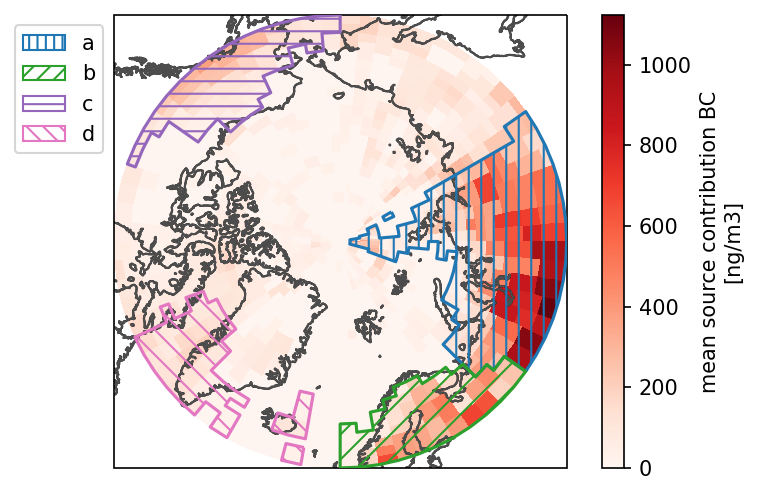

In [90]:
_plt_contr_pol(ds,pol_dic,cf)

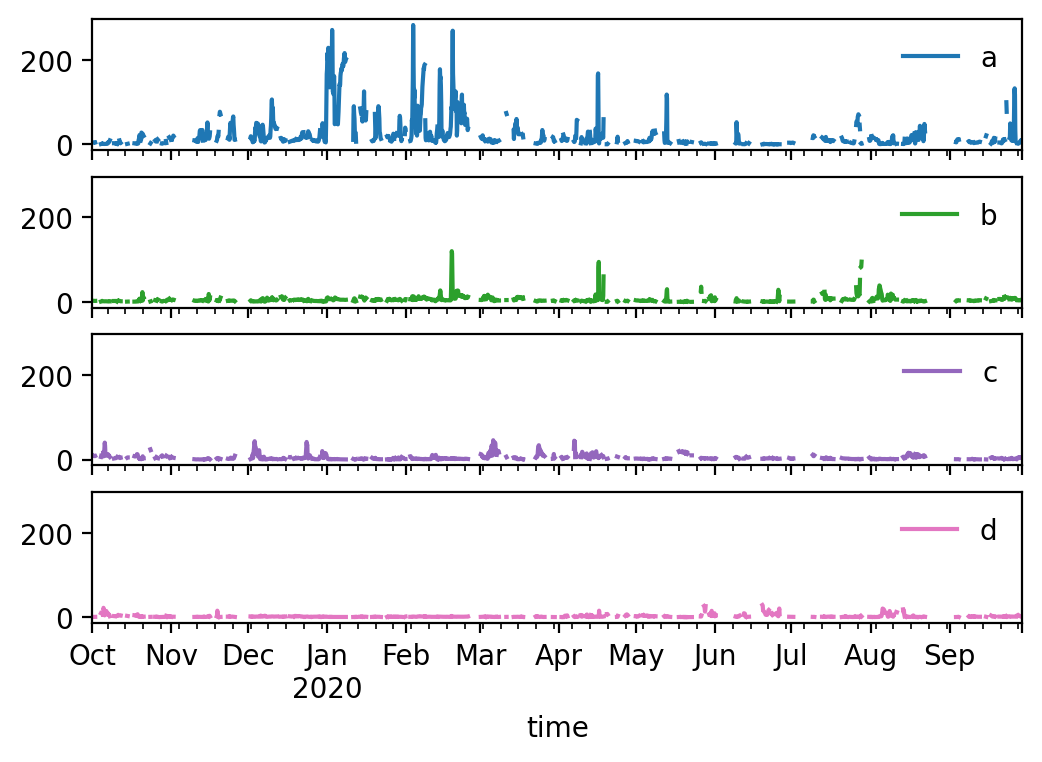

In [148]:
def _plt_ts(pol_dic,cols,df):
    uv  = np.unique(list(pol_dic.values()))
    N = len(uv)

    f,axs = plt.subplots(N,sharex=True,sharey=True,dpi=200)

    _s = pd.Series(pol_dic)

    ts = pd.DataFrame()
    _d = df[yn].resample('3H').mean()[pol_dic.keys()]
    for i,s in enumerate(uv):
        ts[s]=_d[_s[_s==s].index].sum(axis=1)
        ts[[s]][yn].resample('3H').mean().plot(ax=axs[i], c= cols[s])
        axs[i].legend(frameon=False)
    

_plt_ts(pol_dic,cols,df)
    